In [3]:
import csv
from collections import defaultdict
from operator import itemgetter 
import dateutil.parser

In [4]:
turnstile = defaultdict(list)
turnstilets = defaultdict(list)

Q1. Read CSV, make dict where key is first 4 and value is rest. (turnstile)<br>
Q2. Combine Date and Time to datetime object, drop everything in value except datetime and entries

In [5]:
with open('turnstile.csv', 'rb') as ts:
    tsdata = csv.reader(ts)
    header = tsdata.next()
    for row in tsdata:
        key = row[:4]
        key = tuple(key)
        # v is the value for Q1
        v = row[4:]
        # vts is datetime value - date and timestamp
        vts = row[6] + ", " + row[7]
        vts = dateutil.parser.parse(vts)
        # tsvalue is value for Q2
        tsvalue = list()
        tsvalue.append(vts)
        tsvalue.append(int(row[9]))
        # Q1
        turnstile[key].append(v)
        # Q2
        turnstilets[key].append(tsvalue)

In [ ]:
turnstilets['A002','R051','02-00-00','59 ST']

Q3. Every n hours (n = 4). We want daily totals. The total is cumulative so you must subtract.

In [12]:
daily = defaultdict(list)
for k, v in turnstilets.iteritems():
    previous = 0
    current = 0
    delta = 0
    for line in v:
        if v.index(line) % 6 == 0:
            dailyvalue = []
            # convert datetime to date and append to daily value
            dailyvalue.append(line[0].date())
            # current is entries
            current = line[1]
            # today's minus yesterday's
            delta = current - previous
            dailyvalue.append(delta)
            # append date/value pair to key
            # exclude first date of every key
            if previous != 0 and delta >= 0: 
                daily[k].append(dailyvalue)
            previous = current

In [6]:
daily['A002','R051','02-00-00','59 ST'][0:4]

[[datetime.date(2016, 1, 3), 1099],
 [datetime.date(2016, 1, 4), 758],
 [datetime.date(2016, 1, 5), 1758],
 [datetime.date(2016, 1, 6), 1641]]

Q4. plot the daily time series for one turnstile

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts.

In [1]:
dates = [d for d, c in daily['A002','R051','02-00-00','59 ST'].sort()]
counts = [c for d, c in daily['A002','R051','02-00-00','59 ST'].sort()]

NameError: name 'daily' is not defined

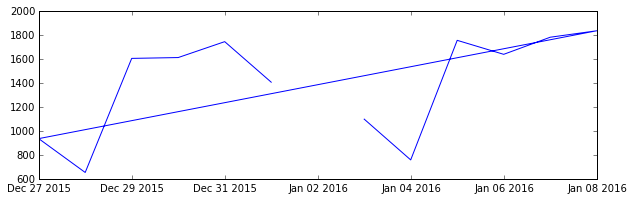

In [14]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

Q5. Combine turnstiles at each ControlArea/Unit/Station combination.